<a href="https://colab.research.google.com/github/mmonem1996/Simple_Dense_Neural_Network/blob/main/Fully_Connected_Layers_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backpropagation Algorithm for Fully Connected Neural Network
The below code implement a simple algorithm for training a fully connected layers of a neural network via ***NeuralNetwork*** class.

The code moves then to apply this class in a simple classification task of idnetifying MNIST hand-written digits.




In [ ]:
import cupy as np # using GPU CUDA features, substitute to numpy to use CPU
from urllib.request import urlretrieve
import gzip, json
from IPython.display import clear_output
from google.colab import drive
from shutil import copyfile
import sklearn.metrics as skm
import pandas as pd

In [ ]:
from matplotlib import pyplot as plt 
%matplotlib inline

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Downloading Datasets

In [ ]:
# downloading training datasets
training_images = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
training_labels = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
urlretrieve(training_images, '/content/training_images.gz')
urlretrieve(training_labels, '/content/training_labels.gz')

('/content/training_labels.gz', <http.client.HTTPMessage at 0x7fe3ec1f03c8>)

In [ ]:
# unzipping training data
with gzip.open('/content/training_images.gz', 'rb') as zfile:
  with open('/content/train-images.idx3-ubyte', 'wb') as decompressed:
    decompressed.write(zfile.read())

with gzip.open('/content/training_labels.gz', 'rb') as zfile:
  with open('/content/train-labels.idx1-ubyte', 'wb') as decompressed:
    decompressed.write(zfile.read())

In [ ]:
# downloading testing datasets
testing_images = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
testing_labels = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
urlretrieve(testing_images, '/content/testing_images.gz')
urlretrieve(testing_labels, '/content/testing_labels.gz')

('/content/testing_labels.gz', <http.client.HTTPMessage at 0x7f101fbaefd0>)

In [ ]:
# unzipping testing data
with gzip.open('/content/testing_images.gz', 'rb') as zfile:
  with open('/content/tk10-images.idx3-ubyte', 'wb') as decompressed:
    decompressed.write(zfile.read())

with gzip.open('/content/testing_labels.gz', 'rb') as zfile:
  with open('/content/tk10-labels.idx1-ubyte', 'wb') as decompressed:
    decompressed.write(zfile.read())

## Auxilary functions

In [ ]:
# activation functions
logistic = lambda z : 1 / (1 + np.exp(-1 * z))   
dlogistic = lambda z : np.cosh(z / 2) ** (-2) / 4

linear = lambda z: z
dlinear = lambda z: np.ones_like(z)

tanh = lambda z: np.tanh(z)
dtanh = lambda z: 1 - (np.tanh(z)**2)
# These 3 lines are for getting the naming right when later serializing the weights and biases in a file
logistic.__name__ = 'logistic'
linear.__name__ = 'linear'
tanh.__name__ = 'tanh'

In [ ]:
# the sturcture of idx3 file is discussed in http://yann.lecun.com/exdb/mnist/
def read_idx3_file_images(file: str):
  with open(file, 'rb') as idx_file:
    idx_file.read(4) # reading out the magic number
    num_of_images = int.from_bytes(idx_file.read(4), 'big')
    nrows = int.from_bytes(idx_file.read(4), 'big')
    ncols = int.from_bytes(idx_file.read(4), 'big')
    images = np.zeros((num_of_images, nrows * ncols), dtype=np.uint8)
    for i in range(num_of_images):
      imi_bytes = list(idx_file.read(nrows * ncols))
      imi = np.array(imi_bytes, dtype=np.uint8)
      images[i, :] = imi
  return images, nrows, ncols

In [ ]:
# the sturcture of idx1 file is discussed in http://yann.lecun.com/exdb/mnist/
def read_idx1_file_labels(file: str):
  with open(file, 'rb') as idx_file:
    idx_file.read(8)
    labels = list(idx_file.read())
  return labels

## Model Training

In [ ]:
class NeuralNetwork:
  def __init__(self, layers, sigma, dsigma):
    self.layers = layers
    self.layers_list = []
    self.sigma = sigma
    self.dsigma = dsigma
    self.reset_network()

  def reset_network(self):
    self.layers_list = []
    prev_layer = self.layers[0]
    np.random.RandomState(42)
    for i in range(1, len(self.layers)):
      layer = self.layers[i]
      wi = np.random.randn(layer, prev_layer)
      bi = np.random.randn(layer, 1)
      prev_layer = layer
      self.layers_list.append([wi, bi])

  def evaluate_network_function(self, x):
    ai = np.array(x)
    assert (len(ai.shape) == 2)
    a_list = [ai]
    z_list = []
    for wi, bi in self.layers_list:
      zi = wi @ ai + bi
      ai = self.sigma(zi)
      z_list.append(zi)
      a_list.append(ai)
    return a_list, z_list

  def evaluate_cost(self, x, y):
    y_hat = self.evaluate_network_function(x)[0][-1]
    return np.linalg.norm(y - y_hat) ** 2 / x.shape[1]

  def evaluate_gradients(self, x, y):
    # The gradients formulaes is the below
    # dC/dwi = dC/dao * [dao/da(o-1) * da(o-1)/da(o-2)*...(da(i+1)/dai)] 
    #         * dai/dzi * dzi/dwi
    # dC/dbi = dC/dao * [dao/da(o-1) * da(o-1)/da(o-2)*...(da(i+1)/dai)] 
    #         * dai/dzi * dzi/dbi
    # dzi/dwi = transpose(a_i-1) and dzi/dbi = 1
    x = np.array(x)
    y = np.array(y)
    a_list, z_list = self.evaluate_network_function(x)
    # This index refer to the output layer
    olayer_ind = len(self.layers) - 1
    # the partial derivative of the cost function wrt the output layer vector
    dC_dao = 2 * (a_list[olayer_ind] - y)
    # The below list will contain the gradients of the weights and biases and will be returned
    gradients = []
    for i in range(olayer_ind, 0, -1):
      j_wi = dC_dao.copy()
      # The below loop calculates the derivatives of layers wrt their previous layers and the derivatives will be
      # consecutively multiplied by gradient j_wi starting from the output layer to the current layer i
      for j in range(olayer_ind, i, -1):
          zj = z_list[j - 1]
          wj = self.layers_list[j - 1][0]
          j_wi *= self.dsigma(zj)
          j_wi = wj.T @ j_wi

      zi = z_list[i - 1]
      j_wi *= self.dsigma(zi)
      j_bi = j_wi.copy()
      j_wi = j_wi @ a_list[i - 1].T / x.shape[1]
      j_bi = np.sum(j_bi, axis=1, keepdims=True) / x.shape[1]
      gradients.insert(0, [j_wi, j_bi])

    return gradients

  def fit(self, x, y, iterations=10000, aggression=10, update_frequency=1000, verbose=True):
    # This function update network's weights and biases via Gradient Descent
    x = np.array(x)
    y = np.array(y)
    # these aressertions to prevent matrix mutliplication 
    assert (len(x.shape) == 2)
    assert (len(y.shape) == 2)
    # Gradient Descent algorithm
    for i in range(iterations):
      grads = self.evaluate_gradients(x, y)
      for j in range(len(self.layers_list)):
        self.layers_list[j][0] = self.layers_list[j][0] - aggression * grads[j][0]
        self.layers_list[j][1] = self.layers_list[j][1] - aggression * grads[j][1]
      if verbose and (((i + 1) % update_frequency) == 0):
        cost = self.evaluate_cost(x, y)
        clear_output(True)
        print('Iteration %d:\tCost = %0.4f' % ((i + 1), cost))
    print('Training is complete!')
  
  def get_serialized_filename(self):
    fmt = '{0}layers_NN_'
    nHUlayers = len(nn.layers) - 1
    for i in range(1, nHUlayers):
      fmt += '{' + f'1[{i}]' + '}_'
    fmt += 'HU_' + self.sigma.__name__ + '_activation.json'
    return fmt.format(nHUlayers, nn.layers)

  def serialize(self, filename=None):
    # Once suitable parameters are reached, it is possible to use this
    # function to save them in json file
    if filename is None:
      filename = self.get_serialized_filename()
    with open(filename, 'w') as param_file:
      ser_layer_list = []
      for wi, bi in self.layers_list:
        wi = wi.tolist()
        bi = bi.tolist()
        ser_layer_list.append([wi, bi])
      json.dump(ser_layer_list, param_file, indent=2)
      

  def load_serialized(self, filename=None):
    # load saved json file
    if filename is None:
      filename = self.get_serialized_filename()
    with open(filename, 'r') as param_file:
      ser_layer_list = json.load(param_file)
      self.layers_list = []
      for wi, bi in ser_layer_list:
        wi = np.array(wi)
        bi = np.array(bi)
        self.layers_list.append([wi, bi])

In [ ]:
images, r, c = read_idx3_file_images('/content/train-images.idx3-ubyte')
labels = read_idx1_file_labels('/content/train-labels.idx1-ubyte')

In [ ]:
# modify size_of_dataset as suitable to hardware, max value is 60000
size_of_dataset = 60000
x = np.asarray(images.T[:,:size_of_dataset], dtype=np.float)
x = x / 255
y = np.zeros((10, size_of_dataset))
for i in range(size_of_dataset):
  y[labels[i], i] = 1.0
del images

In [ ]:

# print((np.min(x), np.max(x)))
# x = (x - np.mean(x, axis=0, keepdims=True))/np.std(x, axis=0, keepdims=True)
nn = NeuralNetwork([28 * 28, 300, 150, 10], logistic, dlogistic)

In [ ]:
nn.fit(x, y, iterations=60000, update_frequency=10, aggression=3)

In [ ]:
grads = nn.evaluate_gradients(x, y)
for wi, bi in grads:
  print((np.linalg.norm(wi), (np.linalg.norm(bi))))

In [ ]:
test_index = 0
o0 = nn.evaluate_network_function(x[:, test_index].reshape(-1,1))[0][-1]
print(np.round_(o0, 4).flatten())
print(np.round_(y[:, test_index], 4))

In [ ]:
al = nn.evaluate_network_function(x)[0][-1]
y_pred = np.argmax(al, axis=0).flatten()
y_true = np.array(labels)
score = skm.accuracy_score(y_pred.tolist(), y_true.tolist())
print('Accuracy score: {:.2f}%'.format(100*score))

Accuracy score: 90.53%


---
## Loading/Unloading NN parameters
The below cells are for loading. modify it to load from your drive or to directly load from the mounted space without using google.drive module.

In [ ]:
src = '/content/gdrive/My Drive/Colab Notebooks/neural_networks/' + nn.get_serialized_filename()
dst = '/content/' + nn.get_serialized_filename()
copyfile(src, dst)
nn.load_serialized()

In [ ]:
nn.serialize()
dst = '/content/gdrive/My Drive/Colab Notebooks/neural_networks/' + nn.get_serialized_filename()
src = '/content/' + nn.get_serialized_filename()
copyfile(src, dst)

'/content/gdrive/My Drive/Colab Notebooks/neural_networks/3layers_NN_500_150_HU_logistic_activation.json'

---
## Model Testing

In [ ]:
images_test, r, c = read_idx3_file_images('/content/tk10-images.idx3-ubyte')
labels_test = read_idx1_file_labels('/content/tk10-labels.idx1-ubyte')

In [ ]:
# modify size_of_dataset as suitable to hardware, max value is 60000
xtest = np.asarray(images_test.T[:,:], dtype=np.float)
xtest = xtest / 255
ytest = np.zeros((10, len(labels_test)))
for i in range(len(labels_test)):
  ytest[labels_test[i], i] = 1

In [ ]:
al = nn.evaluate_network_function(xtest)[0][-1]
y_pred = np.argmax(al, axis=0).flatten()
y_true = np.array(labels_test)
score = skm.accuracy_score(y_pred.tolist(), y_true.tolist())
print('Accuracy score: {:.2f}%'.format(100*score))

Accuracy score: 87.45%


### Sample image testing

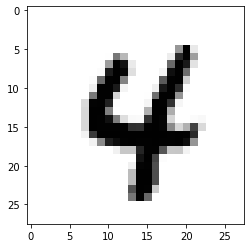

In [ ]:
# acquire a random image from the testing set
sample_image = images_test[np.random.randint(0, len(labels_test)), :].reshape(-1, 1)
plt.imshow(np.asnumpy(sample_image.reshape(28, 28)), cmap='Greys')

In [ ]:
# test the network classifier on the sample image
sample_image = sample_image/255 # mapping to (0, 1) range
predicted_values = nn.evaluate_network_function(sample_image)[0][-1].flatten()
indices = np.argsort(predicted_values)[::-1]
results = np.vstack((indices, np.round_(predicted_values[indices], 3))).T
pv = pd.DataFrame(results, columns=['Recognized Digit', 'Confidence Score'])
pv['Recognized Digit'] = pv['Recognized Digit'].apply(lambda d: int(d))
pv.head()

,Recognized Digit,Confidence Score
0,4,1.0
1,6,0.001
2,9,0.0
3,7,0.0
4,1,0.0


In [ ]:
drive.flush_and_unmount()

---